##1) Install deps

In [1]:
# Colab/Local: open-source stack (no OpenAI)
!pip -q install "transformers>=4.42" "accelerate>=0.31" bitsandbytes \
               "huggingface_hub>=0.23" langgraph langchain pydantic>=2.0 \
               ruff pytest hypothesis python-dotenv

import os, torch
print("CUDA available:", torch.cuda.is_available())


CUDA available: True


##2) Config & model router

In [2]:
import os
from dataclasses import dataclass
from typing import List, Dict, Any, Optional, TypedDict, Literal
from pathlib import Path
import json, re, textwrap, shutil, subprocess, uuid
from datetime import datetime

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# --- Project dirs ---
BASE_DIR = Path.cwd()
REPO_DIR = BASE_DIR / "demo_repo"
ARTIFACTS_DIR = BASE_DIR / "artifacts"
ARTIFACTS_DIR.mkdir(exist_ok=True)

# --- Model choices ---
SMALL_MODEL_ID = os.getenv("SMALL_MODEL_ID", "Qwen/Qwen2.5-Coder-0.5B-Instruct")
BIG_MODEL_ID   = os.getenv("BIG_MODEL_ID",   "Qwen/Qwen2.5-Coder-1.5B-Instruct")

class _Resp:
    def __init__(self, content: str): self.content = content

class HFChat:
    """
    Minimal chat wrapper exposing .invoke(messages)->obj with .content
    Uses tokenizer.apply_chat_template for proper chat formatting.
    """
    def __init__(self, model_id: str, temperature: float = 0.0, max_new_tokens: int = 512):
        self.model_id = model_id
        self.temperature = float(temperature)
        self.max_new_tokens = int(max_new_tokens)

        use_gpu = torch.cuda.is_available()
        load_in_4bit = use_gpu  # enable 4-bit only when GPU is present

        self.tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
        kwargs = {
            "device_map": "auto" if use_gpu else None,
            "low_cpu_mem_usage": True,
        }
        if load_in_4bit:
            kwargs.update(dict(load_in_4bit=True))
        else:
            # CPU path
            kwargs.update(dict(torch_dtype=torch.float32))

        self.model = AutoModelForCausalLM.from_pretrained(model_id, **kwargs)
        # Some models miss pad_token; fall back to eos
        if self.tok.pad_token_id is None and self.tok.eos_token_id is not None:
            self.tok.pad_token = self.tok.eos_token

    def _format(self, messages):
        # Accept list of (role, content) tuples like before
        chat = []
        for role, content in messages:
            # Map our 'tool' messages to 'user' so the model can read outputs
            r = "system" if role == "system" else ("assistant" if role == "assistant" else "user")
            chat.append({"role": r, "content": content})
        try:
            return self.tok.apply_chat_template(
                chat, tokenize=False, add_generation_prompt=True
            )
        except Exception:
            # Fallback simple format
            sys = "\n".join(m["content"] for m in chat if m["role"] == "system")
            conv = "\n".join(f"{m['role'].upper()}: {m['content']}" for m in chat if m["role"]!="system")
            return (sys + "\n" + conv + "\nASSISTANT:").strip()

    def invoke(self, messages):
        prompt = self._format(messages)
        inputs = self.tok(prompt, return_tensors="pt")
        if torch.cuda.is_available():
            inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        with torch.no_grad():
            out = self.model.generate(
                **inputs,
                max_new_tokens=self.max_new_tokens,
                do_sample=self.temperature > 0.0,
                temperature=self.temperature if self.temperature > 0 else None,
                top_p=0.95,
                pad_token_id=self.tok.pad_token_id,
                eos_token_id=self.tok.eos_token_id,
            )
        gen_ids = out[0][inputs["input_ids"].shape[-1]:]
        text = self.tok.decode(gen_ids, skip_special_tokens=True)
        return _Resp(text)

@dataclass
class LLMRouter:
    small_id: str = SMALL_MODEL_ID
    big_id: str = BIG_MODEL_ID
    temperature: float = 0.0
    max_new_tokens: int = 512

    def small(self):
        return HFChat(self.small_id, temperature=self.temperature, max_new_tokens=self.max_new_tokens)

    def big(self):
        # big model for escalation; if OOM, point this to the small model id
        try:
            return HFChat(self.big_id, temperature=self.temperature, max_new_tokens=self.max_new_tokens)
        except Exception as e:
            print(f"[Router] Falling back to SMALL model due to load error: {e}")
            return HFChat(self.small_id, temperature=self.temperature, max_new_tokens=self.max_new_tokens)

llm_router = LLMRouter()


##3) Create a tiny buggy repo (target for the duel)

In [3]:
def bootstrap_demo_repo(repo: Path):
    if repo.exists():
        shutil.rmtree(repo)
    (repo / "tests").mkdir(parents=True, exist_ok=True)

    (repo / "calculator.py").write_text(textwrap.dedent("""
    def add(a, b):
        return a + b

    def mul(a, b):
        return a * b

    # BUG: uses integer floor division and no zero handling
    def divide(a, b):
        return a // b
    """).strip() + "\n")

    (repo / "stringy.py").write_text(textwrap.dedent("""
    def snake_to_camel(s: str) -> str:
        # BUG: naive title() breaks digits/underscores at edges
        return ''.join(part.title() for part in s.split('_'))
    """).strip() + "\n")

    (repo / "tests" / "test_basic.py").write_text(textwrap.dedent("""
    from calculator import add, mul, divide
    def test_add():
        assert add(2, 3) == 5

    def test_mul():
        assert mul(3, 4) == 12

    def test_divide_simple():
        assert divide(8, 2) == 4
    """).strip() + "\n")

    (repo / "pytest.ini").write_text(textwrap.dedent("""
    [pytest]
    addopts = -q
    """).strip() + "\n")

    (repo / "pyproject.toml").write_text(textwrap.dedent("""
    [tool.ruff]
    line-length = 100
    """).strip() + "\n")

bootstrap_demo_repo(REPO_DIR)
print("Demo repo created at:", REPO_DIR)
print("Files:", [str(p.relative_to(REPO_DIR)) for p in REPO_DIR.rglob("*")])


Demo repo created at: /content/demo_repo
Files: ['tests', 'pyproject.toml', 'pytest.ini', 'stringy.py', 'calculator.py', 'tests/test_basic.py']


##4) Tooling layer: repo ops, grep, patch/write, pytest/ruff runners

In [15]:
class RepoTools:
    """Read-only search + controlled writes in a sandboxed folder."""
    def __init__(self, root: Path):
        self.root = root

    def safe_path(self, rel: str) -> Path:
        p = (self.root / rel).resolve()
        if self.root not in p.parents and p != self.root:
            raise ValueError("Path escapes sandbox")
        return p

    def list_files(self, pattern: str = "**/*.py") -> List[str]:
        return [str(p.relative_to(self.root)) for p in self.root.glob(pattern)]

    def read_file(self, rel: str, max_chars: int = 4000) -> str:
        p = self.safe_path(rel)
        content = p.read_text()
        return content[:max_chars]

    def search_repo(self, pattern: str, max_hits: int = 50) -> List[Dict[str, Any]]:
        """Return file, line_no, line for regex pattern."""
        rx = re.compile(pattern)
        hits = []
        for file in self.root.rglob("*.py"):
            lines = file.read_text().splitlines()
            for i, line in enumerate(lines, 1):
                if rx.search(line):
                    hits.append({"file": str(file.relative_to(self.root)), "line": i, "text": line})
                    if len(hits) >= max_hits:
                        return hits
        return hits

    def write_file(self, rel: str, content: str):
        p = self.safe_path(rel)
        p.parent.mkdir(parents=True, exist_ok=True)
        p.write_text(content)

    def apply_json_patch(self, patch: Dict[str, Any]) -> List[str]:
        """
        Patch format:
        {"edits":[{"path":"file.py","after":"<full new file content>"} , ... ]}
        Optionally include "before" to sanity-check; if mismatch, we'll still write.
        """
        changed = []
        for edit in patch.get("edits", []):
            path = edit["path"]
            after = edit["after"]
            self.write_file(path, after)
            changed.append(path)
        return changed

class SandboxRunner:
    """Runs pytest and ruff in a subprocess with captured output."""
    def __init__(self, root: Path):
        self.root = root

    def _run(self, cmd: List[str], timeout: int = 120) -> Dict[str, Any]:
        proc = subprocess.run(
            cmd,
            cwd=self.root,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            timeout=timeout,
            env={**os.environ, "PYTHONPATH": str(self.root)},
        )
        return {"ok": proc.returncode == 0, "returncode": proc.returncode, "output": proc.stdout}

    def run_tests(self) -> Dict[str, Any]:
        return self._run(["pytest"])

    def run_ruff(self) -> Dict[str, Any]:
        # Ruff v0.6+ expects an explicit subcommand
        return self._run(["ruff", "check", "."])


repo_tools = RepoTools(REPO_DIR)
runner = SandboxRunner(REPO_DIR)
print("Initial pytest run:", runner.run_tests()["ok"])


Initial pytest run: True


##5) Reflexion memory

In [5]:
class ReflexionMemory:
    def __init__(self, path: Path):
        self.path = path
        self.data = {"notes": []}
        if path.exists():
            try:
                self.data = json.loads(path.read_text())
            except Exception:
                pass

    def add(self, kind: str, text: str, meta: Optional[dict] = None):
        self.data["notes"].append({
            "id": str(uuid.uuid4()),
            "ts": datetime.utcnow().isoformat() + "Z",
            "kind": kind,
            "text": text,
            "meta": meta or {},
        })
        self.save()

    def save(self):
        self.path.write_text(json.dumps(self.data, indent=2))

    def summary(self) -> str:
        if not self.data["notes"]:
            return "(no notes yet)"
        last = self.data["notes"][-5:]
        return "\n".join(f"- [{n['kind']}] {n['text']}" for n in last)

memory = ReflexionMemory(ARTIFACTS_DIR / "reflexion_memory.json")
memory.add("init", "Duel initialized; target: simple Python repo with math/string utilities.")
print(memory.summary())


- [referee] pytest ok=True
- [referee] pytest ok=True
- [referee] pytest ok=True
- [referee] pytest ok=True
- [init] Duel initialized; target: simple Python repo with math/string utilities.


###Tracer utilities (artifacts + verbose logs)

In [16]:
from datetime import datetime

class Tracer:
    def __init__(self, root: Path):
        self.root = root
        self.active = None

    def start(self, session_id: str):
        self.active = session_id
        d = self.dir
        d.mkdir(parents=True, exist_ok=True)
        return d

    @property
    def dir(self) -> Path:
        sid = self.active or "latest"
        return self.root / f"logs_{sid}"

    def log_text(self, name: str, content: str) -> Path:
        p = self.dir / name
        p.write_text(content)
        return p

    def log_json(self, name: str, obj: dict) -> Path:
        return self.log_text(name, json.dumps(obj, indent=2))

tracer = Tracer(ARTIFACTS_DIR)
VERBOSE = True


In [26]:
import textwrap, difflib

LIVE_VERBOSE = True

def say(agent: str, header: str, text: str, max_chars: int = 1200):
    if not LIVE_VERBOSE:
        return
    clip = text if len(text) <= max_chars else (text[:max_chars] + "\n...[truncated]...")
    print(f"\n[{agent}] {header}\n" + textwrap.indent(clip, "  "))

def unified_diff_str(before: str, after: str, path: str) -> str:
    return "\n".join(
        difflib.unified_diff(
            before.splitlines(), after.splitlines(),
            fromfile=f"{path}:before", tofile=f"{path}:after", lineterm=""
        )
    )


##6) A tiny ReAct loop (tools) + helpers

In [27]:
class JSONExtractor:
    """Robustly extract the first JSON object in a string."""
    @staticmethod
    def extract(s: str) -> Optional[dict]:
        m = re.search(r"\{[\s\S]*\}", s)
        if not m:
            return None
        try:
            return json.loads(m.group(0))
        except Exception:
            try:
                # Try to fix trailing commas
                fixed = re.sub(r",\s*}", "}", m.group(0))
                fixed = re.sub(r",\s*]", "]", fixed)
                return json.loads(fixed)
            except Exception:
                return None

TOOLS_SPEC = """
You can call one tool at a time using this JSON:
{"tool": "<one of: search_repo, read_file, run_tests, run_linter, propose_patch>", "args": {...}}

- search_repo: args={"pattern": "<regex>"} -> returns matches (file,line,text)
- read_file:   args={"path": "<relpath>", "max_chars": 4000}
- run_tests:   args={}
- run_linter:  args={}
- propose_patch: args={
   "edits": [{"path":"<file>", "after":"<full new file content>"} , ...]
}
Rules:
- Prefer searching and reading before proposing a patch.
- Patches must replace the FULL file content(s) (safer for automation).
- Don’t delete existing tests.
- Keep changes minimal; focus on failing cases first.
- Always respond with that JSON ONLY. No prose.
"""

def react_loop(goal: str, repo: RepoTools, runner: SandboxRunner, llm,
               max_iters: int = 4, session_id: Optional[str] = None) -> Dict[str, Any]:
    messages = [
        ("system", "You are the Builder. Use repo tools to fix failing tests with minimal, safe edits."),
        ("system", TOOLS_SPEC),
        ("user", goal),
    ]
    trace = []
    for step in range(max_iters):
        # SHOW prompt sent to model (compact)
        prompt_for_view = f"[system x2] + user(goal len={len(goal)})"
        say("Builder-ReAct", f"STEP {step}: PROMPT SUMMARY", prompt_for_view)

        resp = llm.invoke(messages).content
        trace.append(("assistant", resp))
        if VERBOSE:
            tracer.log_text(f"builder_step{step}_assistant.txt", resp)

        say("Builder-ReAct", f"STEP {step}: MODEL JSON", resp)

        payload = JSONExtractor.extract(resp)
        if not payload or "tool" not in payload:
            say("Builder-ReAct", f"STEP {step}: PARSE ERROR", "No valid JSON tool call found.")
            break

        tool, args = payload["tool"], payload.get("args", {})
        if tool == "search_repo":
            out = repo.search_repo(args.get("pattern", ""))
        elif tool == "read_file":
            out = repo.read_file(args["path"], args.get("max_chars", 4000))
        elif tool == "run_tests":
            out = runner.run_tests()
        elif tool == "run_linter":
            out = runner.run_ruff()
        elif tool == "propose_patch":
            changed = []
            for edit in args.get("edits", []):
                path, after = edit["path"], edit["after"]
                try:
                    before = repo.read_file(path, 20000)
                except Exception:
                    before = ""
                repo.write_file(path, after)
                diff = unified_diff_str(before, after, path)
                tracer.log_text(f"diff_{path.replace('/', '_')}.patch", diff)
                say("Builder-ReAct", f"APPLIED PATCH → {path}", diff if diff.strip() else "(new file)")
                changed.append(path)
            out = {"applied": changed}
        else:
            out = {"error": f"unknown tool {tool}"}

        # SHOW tool output (compact)
        show = out if isinstance(out, str) else json.dumps(out, indent=2)
        say("Builder-ReAct", f"STEP {step}: TOOL={tool}", show)

        messages.append(("tool", json.dumps(out)[:6000]))
        if tool == "propose_patch":
            return {"trace": trace, "applied": out, "messages": messages}

    return {"trace": trace, "messages": messages}




##7) Breaker (test generator) + Critic (gate) prompts

In [28]:
BREAKER_INSTR = """
You're the Breaker. Study the repository & existing tests. Write ONE additional pytest file that
captures a realistic edge case the current code fails. Prefer property-based tests (hypothesis)
when helpful. The test should be minimal but failing BEFORE the fix.

Return JSON ONLY:
{
  "path": "tests/test_breaker_<slug>.py",
  "content": "<full file content>"
}
Rules:
- Import only from repo modules (no internet or new deps except 'hypothesis').
- Keep test names descriptive.
- Avoid duplicating existing tests.
"""

CRITIC_INSTR = """
You're the Critic. Review the Builder's patch. Check for risky edits, deleted tests, and style issues.
Return JSON ONLY:
{
  "approve": true|false,
  "reason": "<short>",
  "micro_fixes": {
      "edits": [{"path":"<file>", "after":"<full new content>"}]
  }
}
- Approve only if patch is minimal, safe, and tests/linter likely pass.
- If reject, include concrete micro_fixes when possible (same patch format).
"""

def propose_failing_test(llm, repo: RepoTools) -> Dict[str, Any]:
    context = {
        "files": repo.list_files("**/*.py"),
        "sample_calculator": repo.read_file("calculator.py"),
        "sample_stringy": repo.read_file("stringy.py"),
        "existing_tests": repo.read_file("tests/test_basic.py"),
    }
    prompt = [
        ("system", BREAKER_INSTR),
        ("user", "Repository context:\n" + json.dumps(context)[:6000])
    ]
    out = llm.invoke(prompt).content
    payload = JSONExtractor.extract(out) or {}
    return payload

def critic_review(llm, diff_summary: str) -> Dict[str, Any]:
    prompt = [
        ("system", CRITIC_INSTR),
        ("user", f"Diff summary:\n{diff_summary[:6000]}")
    ]
    out = llm.invoke(prompt).content
    return JSONExtractor.extract(out) or {"approve": False, "reason": "Bad JSON"}


In [29]:
PLANNER_SPEC = """
You're a planning module for a code-fixing agent. Produce 2–4 succinct candidate plans,
then pick ONE. Return JSON ONLY:

{
  "plans": [
    {"name": "read failing output", "steps": ["run tests", "locate failing func", "patch minimal", "re-run tests"]},
    {"name": "grep & localize", "steps": ["search_repo to find symbol", "open file", "propose_patch", "ruff check"]}
  ],
  "selected": 0
}

Rules: keep names <= 5 words; steps are imperative verbs; no prose.
"""

BREAKER_BRAINSTORM_SPEC = """
You're a brainstorming module for a test-breaking agent. Invent 2–4 realistic edge cases
for NEW failing tests on this repo. Return JSON ONLY:

{
  "ideas": [
    {"title": "division by zero", "file": "tests/test_breaker_divzero.py",
     "summary": "assert divide(1,0) raises", "style": "pytest"},
    {"title": "snake digits boundary", "file": "tests/test_breaker_snake_digits.py",
     "summary": "snake_to_camel('9hello_world') -> '9helloWorld'", "style": "pytest"}
  ],
  "selected": 0
}
"""

def builder_plan(llm, failing_text: str, file_list: list) -> dict:
    prompt = [
        ("system", PLANNER_SPEC),
        ("user", f"Failing summary (truncated):\n{failing_text[:1500]}\n\nFiles:\n{file_list[:50]}")
    ]
    out = llm.invoke(prompt).content
    plan = JSONExtractor.extract(out) or {"plans":[{"name":"default","steps":["run tests","patch","re-run"]}],"selected":0}
    tracer.log_json("builder_plans.json", plan)
    return plan

def breaker_brainstorm(llm, repo: RepoTools) -> dict:
    ctx = {
        "files": repo.list_files("**/*.py"),
        "tests": [str(p) for p in (repo.root / "tests").glob("*.py")]
    }
    prompt = [("system", BREAKER_BRAINSTORM_SPEC), ("user", json.dumps(ctx)[:5000])]
    out = llm.invoke(prompt).content
    ideas = JSONExtractor.extract(out) or {"ideas":[{"title":"division by zero","file":"tests/test_breaker_divzero.py","summary":"assert divide(1,0) raises","style":"pytest"}],"selected":0}
    tracer.log_json("breaker_ideas.json", ideas)
    return ideas


In [33]:
ENABLE_DEBATE = True

DEBATE_PRO_SPEC = """
You are the Builder-Hypothesis module. Summarize the fix you believe addresses the failing tests.
Return JSON ONLY:
{
  "hypothesis": "<one sentence on the change/fix>",
  "claims": ["<assertion 1>", "<assertion 2>"],
  "risky_files": ["calculator.py", "stringy.py"]
}
Rules: be concise; no prose beyond JSON.
"""

DEBATE_CON_SPEC = """
You are the Breaker-Counterexample module. Given the builder's hypothesis+claims and the repository,
either produce a minimal failing test that challenges it, or accept the hypothesis.
Return JSON ONLY:
{
  "decision": "challenge" | "accept",
  "counterexample": "<short text why it might fail>",
  "test": {
    "path": "tests/test_debate_<slug>.py",
    "content": "<full pytest file or property-based test using hypothesis>"
  }
}
Rules:
- Prefer real failing tests.
- Keep the test minimal and specific to the hypothesis.
- If you accept, set "test" to null.
"""

def builder_hypothesis(llm, failing_text: str, changed_files: list) -> dict:
    prompt = [
        ("system", DEBATE_PRO_SPEC),
        ("user", f"Recent changes: {changed_files}\n\nFailing output (trunc):\n{failing_text[:2000]}")
    ]
    out = llm.invoke(prompt).content
    payload = JSONExtractor.extract(out) or {
        "hypothesis": "Minimal patch fixes logic; validate edges",
        "claims": ["division by zero handled", "snake_to_camel keeps digits"],
        "risky_files": changed_files
    }
    tracer.log_json("debate_builder_hypothesis.json", payload)
    say("Debate-Builder", "HYPOTHESIS", json.dumps(payload, indent=2))
    return payload

def breaker_counterexample(llm, hypothesis: dict, repo: RepoTools) -> dict:
    ctx = {
        "files": repo.list_files("**/*.py"),
        "tests": [str(p) for p in (repo.root / "tests").glob("*.py")],
        "hypothesis": hypothesis
    }
    prompt = [("system", DEBATE_CON_SPEC), ("user", json.dumps(ctx)[:6000])]
    out = llm.invoke(prompt).content
    payload = JSONExtractor.extract(out) or {"decision":"accept","counterexample":"","test":None}
    tracer.log_json("debate_breaker_counterexample.json", payload)
    say("Debate-Breaker", "COUNTEREXAMPLE", json.dumps(payload, indent=2))
    return payload


##8) LangGraph state + nodes

In [34]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver  # in-memory checkpointer

class DuelState(TypedDict):
    turn: int
    budget: int
    route: Literal["referee","builder","breaker","end"]
    last_test_ok: bool
    last_output: str
    changed_files: List[str]
    memory_notes: List[str]

# Shared context object
class Context:
    def __init__(self, repo: RepoTools, runner: SandboxRunner, memory: ReflexionMemory,
                 router: LLMRouter, tracer: Tracer):
        self.repo = repo
        self.runner = runner
        self.memory = memory
        self.router = router
        self.tracer = tracer
        self.session_id = "latest"  # will be set per duel

ctx = Context(repo_tools, runner, memory, llm_router, tracer)

# ------ Node functions ------

def supervisor_node(state: DuelState) -> Dict[str, Any]:
    """Decide next route & advance the duel turn counter."""
    turn = state["turn"]
    budget = state["budget"]

    # Always advance the turn each time supervisor runs
    next_turn = turn + 1

    if turn == 0:
        route = "referee"         # establish baseline on the very first cycle
    elif turn >= budget:
        route = "end"
    else:
        # If last tests passed, try to break; otherwise, fix
        route = "breaker" if state["last_test_ok"] else "builder"

    return {"route": route, "turn": next_turn}

def breaker_node(state: DuelState) -> Dict[str, Any]:
    llm = ctx.router.small()

    ideas = breaker_brainstorm(llm, ctx.repo)
    say("Breaker-Ideas", "BRAINSTORM", json.dumps(ideas, indent=2))
    choice = ideas.get("selected", 0)
    picked = ideas.get("ideas", [{}])[choice] if ideas.get("ideas") else {}
    say("Breaker-Ideas", "SELECTED", json.dumps(picked, indent=2))

    prompt = [
        ("system", "Write ONE pytest file for the selected idea. Return JSON ONLY: {\"path\":..., \"content\":...}"),
        ("user", f"Selected idea: {json.dumps(picked)}\n\nRepo files: {ctx.repo.list_files('**/*.py')[:40]}")
    ]
    out = llm.invoke(prompt).content
    say("Breaker-Writer", "MODEL JSON", out)
    payload = JSONExtractor.extract(out) or {}

    path, content = payload.get("path"), payload.get("content", "")
    changed, msg = [], "Breaker: no valid test produced."
    if path and content:
        ctx.repo.write_file(path, content)
        ctx.tracer.log_text(f"breaker_test_{Path(path).name}", content)
        say("Breaker-Writer", f"WROTE TEST {path}", content)
        changed = [path]
        msg = f"Breaker added test: {path}"

    t = ctx.runner.run_tests()
    ctx.tracer.log_text("breaker_pytest.txt", t["output"])
    say("Breaker-Runner", "PYTEST RESULT", t["output"])
    return {"changed_files": changed, "last_output": msg, "route": "referee"}



def builder_node(state: DuelState) -> Dict[str, Any]:
    llm = ctx.router.small() if state["turn"] < 3 else ctx.router.big()

    # Baseline signals
    test_out = ctx.runner.run_tests()
    lint_out = ctx.runner.run_ruff()
    ctx.tracer.log_text("builder_input_pytest.txt", test_out["output"])
    ctx.tracer.log_text("builder_input_ruff.txt", lint_out["output"])
    say("Builder", "FAILING TESTS (trunc)", test_out["output"][:800])
    say("Builder", "LINTER (trunc)", lint_out["output"][:400])

    # Plan-and-Execute (ToT planner already defined)
    plan = builder_plan(llm, test_out["output"], ctx.repo.list_files("**/*.py"))
    say("Builder-Planner", "PLANS", json.dumps(plan, indent=2))
    chosen_steps = plan.get("plans", [{}])[plan.get("selected", 0)].get("steps", [])
    say("Builder-Planner", "SELECTED STEPS", "\n".join(f"- {s}" for s in chosen_steps))

    # ReAct tool loop -> propose_patch
    subgoals = "\n".join(f"- {s}" for s in chosen_steps)
    goal = f"""
    Subgoals to execute (strict order):
    {subgoals}

    Failing tests (truncated):
    {test_out['output'][:3000]}

    Linter (truncated):
    {lint_out['output'][:1200]}

    Use tools; finish with propose_patch.
    """
    trace = react_loop(goal.strip(), ctx.repo, ctx.runner, llm, max_iters=4, session_id=ctx.session_id)
    changed = trace.get("applied", {}).get("applied", []) if trace.get("applied") else []

    # === NEW: Debate round BEFORE Critic ===
    if ENABLE_DEBATE:
        hyp = builder_hypothesis(llm, test_out["output"], changed)
        con = breaker_counterexample(ctx.router.small(), hyp, ctx.repo)

        # If Breaker produced a challenge test, write it and show
        t = con.get("test")
        if con.get("decision") == "challenge" and isinstance(t, dict) and t.get("path") and t.get("content"):
            path, content = t["path"], t["content"]
            ctx.repo.write_file(path, content)
            ctx.tracer.log_text(f"debate_test_{Path(path).name}", content)
            say("Debate-Breaker", f"ADDED TEST {path}", content)
            # Optional quick run to preview effect (Referee will run formally next)
            preview = ctx.runner.run_tests()
            ctx.tracer.log_text("debate_preview_pytest.txt", preview["output"])
            say("Debate-Preview", "PYTEST RESULT", preview["output"][:800])

    # Critic gate AFTER debate
    critic = critic_review(ctx.router.big(), f"Files changed by builder: {changed}")
    ctx.tracer.log_json("critic_review.json", critic)
    say("Critic", "REVIEW", json.dumps(critic, indent=2))
    approved = bool(critic.get("approve", False))
    if not approved and "micro_fixes" in critic:
        try:
            more = ctx.repo.apply_json_patch(critic["micro_fixes"])
            for ch in more:
                ctx.tracer.log_text(f"critic_fix_{ch.replace('/', '_')}", ctx.repo.read_file(ch, 20000))
                say("Critic", f"MICRO-FIX APPLIED {ch}", ctx.repo.read_file(ch, 800))
            changed.extend(more)
        except Exception:
            pass

    ctx.memory.add("builder", f"Plan steps={len(chosen_steps)}; edits={changed}; critic_approved={approved}")
    msg = f"Builder applied: {changed}; Critic approved: {approved}"
    return {"changed_files": changed, "last_output": msg, "route": "referee"}


def referee_node(state: DuelState) -> Dict[str, Any]:
    """Run tests & linter; update last_test_ok and route back to supervisor."""
    t = ctx.runner.run_tests()
    l = ctx.runner.run_ruff()
    ok = bool(t["ok"])
    summary = f"pytest ok={ok} rc={t['returncode']}\n---- pytest ----\n{t['output'][:1500]}\n---- ruff ----\n{l['output'][:800]}"
    ctx.memory.add("referee", f"pytest ok={ok}")
    return {"last_test_ok": ok, "last_output": summary, "route": "builder" if not ok else "supervisor"}

# ------ Build the graph ------
graph = StateGraph(DuelState)
graph.add_node("supervisor", supervisor_node)
graph.add_node("breaker", breaker_node)
graph.add_node("builder", builder_node)
graph.add_node("referee", referee_node)

graph.add_edge(START, "supervisor")

def route_from_supervisor(state: DuelState):
    return state["route"]

graph.add_conditional_edges("supervisor", route_from_supervisor, {
    "referee": "referee",
    "builder": "builder",
    "breaker": "breaker",
    "end": END,
})
graph.add_edge("builder", "referee")
graph.add_edge("breaker", "referee")

def route_from_referee(state: DuelState):
    # After referee, always go back to supervisor to decide next step
    return "supervisor"

graph.add_conditional_edges("referee", route_from_referee, {"supervisor": "supervisor"})

app = graph.compile(checkpointer=MemorySaver())

print("Graph compiled.")


Graph compiled.


##9) Visualize the graph (optional)

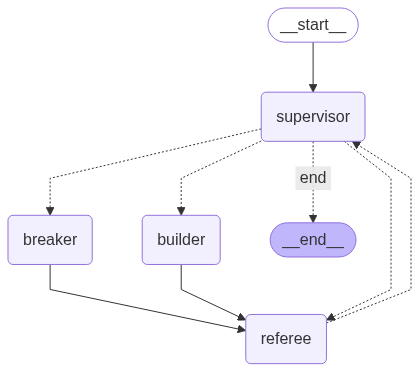

In [31]:
try:
    from IPython.display import Image, display
    png = app.get_graph().draw_mermaid_png()
    display(Image(png))
except Exception as e:
    print("Graph visualization skipped:", e)


##10) Run one full “duel”

In [35]:
from uuid import uuid4

session_id = f"duel-{uuid4().hex[:8]}"
CFG = {
    "configurable": {"thread_id": session_id},
    "recursion_limit": 60,   # prevent infinite recursion
}

ctx.session_id = session_id
tracer.start(session_id)

initial: DuelState = {
    "turn": 0,
    "budget": 8,
    "route": "referee",
    "last_test_ok": False,
    "last_output": "",
    "changed_files": [],
    "memory_notes": [],
}

print(f"=== Running duel (session: {session_id}) ===")
last_state = None
for event in app.stream(initial, config=CFG, stream_mode="values"):
    last_state = event
    print(
        f"[turn={event['turn']:>2}] route={event['route']:<10} ok={str(event['last_test_ok']):<5} "
        f"| changed={len(event.get('changed_files', []))}"
    )
    if VERBOSE and event.get("last_output"):
        # Keep it readable
        excerpt = event["last_output"][:400].rstrip()
        tracer.log_text(f"turn_{event['turn']:02d}_summary.txt", event["last_output"])
        print("  ↳", excerpt.replace("\n", " ")[:200], "...")

print("\n=== Duel summary ===")
print("Final OK:", last_state["last_test_ok"])
print(last_state["last_output"][:800])
print("\nArtifacts dir:", tracer.dir)
print("\nRecent memory:\n", memory.summary())


=== Running duel (session: duel-ecfc64bf) ===
[turn= 0] route=referee    ok=False | changed=0
[turn= 1] route=referee    ok=False | changed=0
[turn= 1] route=supervisor ok=True  | changed=0
  ↳ pytest ok=True rc=0 ---- pytest ---- ...                                                                      [100%] 3 passed in 0.13s  ---- ruff ---- All checks passed! ...
[turn= 2] route=breaker    ok=True  | changed=0
  ↳ pytest ok=True rc=0 ---- pytest ---- ...                                                                      [100%] 3 passed in 0.13s  ---- ruff ---- All checks passed! ...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

##11) Try another round that forces Breaker → new failing case

In [13]:
CFG2 = {"configurable": {"thread_id": f"duel-{uuid4().hex}"}}
state2 = app.invoke(initial, config=CFG2)  # runs until END
print("Baseline OK:", state2["last_test_ok"])
print(state2["last_output"][:400])


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The `load_

Baseline OK: True
pytest ok=True rc=0
---- pytest ----
...                                                                      [100%]
3 passed in 0.12s

---- ruff ----
error: unrecognized subcommand '.'

Usage: ruff [OPTIONS] <COMMAND>

For more information, try '--help'.



##12) Configuration knobs (models, budgets, escalation)

In [36]:
from uuid import uuid4

def run_duel(budget=10, verbose=True):
    sess = f"duel-{uuid4().hex[:8]}"
    ctx.session_id = sess
    tracer.start(sess)
    cfg = {
        "configurable": {"thread_id": sess},
        "recursion_limit": 80
    }
    state = {
        "turn": 0, "budget": budget, "route": "referee",
        "last_test_ok": False, "last_output": "", "changed_files": [], "memory_notes": [],
    }
    # Use stream for visibility; collect last state
    last = None
    for ev in app.stream(state, config=cfg, stream_mode="values"):
        last = ev
        if verbose:
            print(f"[turn={ev['turn']}] route={ev['route']} ok={ev['last_test_ok']}")
    return last

final_state = run_duel()
print("Final OK:", final_state["last_test_ok"])
print(final_state["last_output"][:600])
print("Artifacts dir:", tracer.dir)


[turn=0] route=referee ok=False
[turn=1] route=referee ok=False
[turn=1] route=supervisor ok=True
[turn=2] route=breaker ok=True


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[Breaker-Ideas] BRAINSTORM
  {
    "ideas": [
      {
        "title": "stringy.py",
        "file": "tests/test_basic.py",
        "summary": "assert stringy('') == 'stringy'",
        "style": "pytest"
      },
      {
        "title": "calculator.py",
        "file": "tests/test_basic.py",
        "summary": "assert calculator(5, 3) == 1.6666666666666666",
        "style": "pytest"
      },
      {
        "title": "test_basic.py",
        "file": "tests/test_basic.py",
        "summary": "assert basic() == 'Hello, World!'",
        "style": "pytest"
      }
    ],
    "selected": 0
  }

[Breaker-Ideas] SELECTED
  {
    "title": "stringy.py",
    "file": "tests/test_basic.py",
    "summary": "assert stringy('') == 'stringy'",
    "style": "pytest"
  }

[Breaker-Writer] MODEL JSON
  ```json
  {
    "path": "stringy.py",
    "content": """
  import string

  def stringy(s):
      return s.replace(" ", "")
    """
  }
  ```

[Breaker-Runner] PYTEST RESULT
  ...                        

In [37]:
from pathlib import Path
from textwrap import indent

print("Artifacts dir:", tracer.dir)
files = sorted(tracer.dir.glob("*"))

def head(p: Path, n=60):
    txt = p.read_text(errors="ignore")
    lines = txt.splitlines()
    return "\n".join(lines[:n])

for p in files:
    if p.suffix in {".json", ""} or p.name.endswith(".txt"):
        print("\n▸", p.name)
        print(indent(head(p, 40), prefix="    "))


Artifacts dir: /content/artifacts/logs_duel-09297099

▸ breaker_ideas.json
    {
      "ideas": [
        {
          "title": "stringy.py",
          "file": "tests/test_basic.py",
          "summary": "assert stringy('') == 'stringy'",
          "style": "pytest"
        },
        {
          "title": "calculator.py",
          "file": "tests/test_basic.py",
          "summary": "assert calculator(5, 3) == 1.6666666666666666",
          "style": "pytest"
        },
        {
          "title": "test_basic.py",
          "file": "tests/test_basic.py",
          "summary": "assert basic() == 'Hello, World!'",
          "style": "pytest"
        }
      ],
      "selected": 0
    }

▸ breaker_pytest.txt
    ...                                                                      [100%]
    3 passed in 0.20s


In [39]:
from pathlib import Path
from pprint import pprint
print("Artifacts:", tracer.dir)
for name in ["debate_builder_hypothesis.json", "debate_breaker_counterexample.json",
             "debate_preview_pytest.txt"]:
    p = tracer.dir / name
    if p.exists():
        print("\n▸", name)
        print(p.read_text()[:1200])

Artifacts: /content/artifacts/logs_duel-09297099


In [41]:
# === Export the latest duel results into docs/ (GitHub-friendly) ===
from pathlib import Path
import shutil, json, datetime

ROOT = Path.cwd()
ART = ROOT / "artifacts"
DOCS = ROOT / "docs"
DOCS.mkdir(exist_ok=True)

# 1) Find latest duel dir
duels = sorted(
    [p for p in ART.glob("logs_duel-*") if p.is_dir()],
    key=lambda p: p.stat().st_mtime,
    reverse=True,
)
if not duels:
    raise RuntimeError("No duel logs found in artifacts/. Run a duel first.")
latest = duels[0]
duel_id = latest.name.replace("logs_", "")

# 2) Make target folder
target = DOCS / "duel_logs" / duel_id
target.mkdir(parents=True, exist_ok=True)

# 3) Copy a curated set of artifacts (small, readable)
def copy_if_exists(rel_name: str):
    p = latest / rel_name
    if p.exists() and p.is_file() and p.stat().st_size < 300_000:
        shutil.copy2(p, target / p.name)

def copy_glob(pattern: str):
    for p in latest.glob(pattern):
        if p.is_file() and p.stat().st_size < 300_000:
            shutil.copy2(p, target / p.name)

# Key JSONs
for name in [
    "builder_plans.json",
    "breaker_ideas.json",
    "critic_review.json",
    "debate_builder_hypothesis.json",
    "debate_breaker_counterexample.json",
]:
    copy_if_exists(name)

# Short text logs
for name in [
    "builder_input_pytest.txt",
    "builder_input_ruff.txt",
    "breaker_pytest.txt",
    "debate_preview_pytest.txt",
]:
    copy_if_exists(name)

# Diffs and generated code
copy_glob("diff_*.patch")
copy_glob("builder_patch_*.py")
copy_glob("critic_fix_*.py")
copy_glob("breaker_test_*.py")
copy_glob("debate_test_*.py")
copy_glob("turn_*_summary.txt")

# 4) Render the graph image (if available)
try:
    png = app.get_graph().draw_mermaid_png()
    (DOCS / "graph.png").write_bytes(png)
except Exception as e:
    print("Graph render skipped:", e)

# 5) Generate docs/RESULTS.md with links and collapsible previews
ts = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
files = sorted([p.name for p in target.iterdir() if p.is_file()])

def fence(title: str, rel_path: str, max_lines: int = 80) -> str:
    p = target / rel_path
    if not p.exists():
        return ""
    text = p.read_text(errors="ignore")
    lines = text.splitlines()
    head = "\n".join(lines[:max_lines])
    more = "" if len(lines) <= max_lines else "\n... [truncated]\n"
    lang = "json" if rel_path.endswith(".json") else ("diff" if rel_path.endswith(".patch") else "text")
    return (
        "\n<details><summary><code>{}</code></summary>\n\n"
        "**{}**\n\n"
        "```{}\n"
        "{}{}\n"
        "```\n"
        "</details>\n"
    ).format(rel_path, title, lang, head, more)

md_parts = []
md_parts.append(f"# Results — {duel_id}\n")
md_parts.append(f"*Generated on {ts}*\n\n")
if (DOCS / "graph.png").exists():
    md_parts.append("![Graph](graph.png)\n\n")

md_parts.append("## Artifacts\n")
for name in files:
    md_parts.append(f"- [{name}](duel_logs/{duel_id}/{name})\n")

md_parts.append("\n---\n")
md_parts.append("## Highlights\n")
md_parts.append(fence("Builder plans (ToT)", "builder_plans.json"))
md_parts.append(fence("Breaker ideas (ToT)", "breaker_ideas.json"))
md_parts.append(fence("Builder hypothesis (Debate)", "debate_builder_hypothesis.json"))
md_parts.append(fence("Breaker counterexample (Debate)", "debate_breaker_counterexample.json"))
md_parts.append(fence("Pytest result (Breaker quick run)", "breaker_pytest.txt", 60))
md_parts.append(fence("Pytest result (Debate preview)", "debate_preview_pytest.txt", 60))
md_parts.append(fence("Pytest (Builder input)", "builder_input_pytest.txt", 60))
md_parts.append(fence("Ruff (Builder input)", "builder_input_ruff.txt", 60))

(DOCS / "RESULTS.md").write_text("".join(md_parts), encoding="utf-8")

print("Exported to:", target)
print("Open docs/RESULTS.md and add a link in README.")


Exported to: /content/docs/duel_logs/duel-09297099
Open docs/RESULTS.md and add a link in README.


In [42]:
# Zip docs/ and download in Colab
from pathlib import Path
import shutil, datetime

DOCS = Path("docs")
assert DOCS.exists(), "docs/ not found — run the export cell first."

ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
zip_base = f"/content/builder-vs-breaker-docs-{ts}"
zip_path = shutil.make_archive(zip_base, "zip", DOCS)

from google.colab import files
files.download(zip_path)  # prompts a download of the ZIP


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>